In [ ]:
# Installation
!pip install xgboost scikit-learn optuna imbalanced-learn matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.2 MB/s eta 0:00:00


In [ ]:
#comparaison de differentes models

#  Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import optuna
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
#  Données
df = pd.read_csv("/home/nada/Project_odoo_17_IA-main/ML_Risque de depart/train_with_risk.csv")

#  Cible
le = LabelEncoder()
df['Risk_Level_encoded'] = le.fit_transform(df['Risk_Level'])
y = df['Risk_Level_encoded']
X = df.drop(columns=['Employee ID', 'Attrition', 'Attrition_Binary', 'Risk_Score', 'Risk_Level', 'Risk_Level_encoded'])

# Prétraitement
ordinal_map = {
    'Work-Life Balance': ['Poor', 'Fair', 'Good', 'Excellent'],
    'Job Satisfaction': ['Low', 'Medium', 'High', 'Very High'],
    'Performance Rating': ['Low', 'Below Average', 'Average', 'High'],
    'Employee Recognition': ['Low', 'Medium', 'High', 'Very High'],
    'Company Reputation': ['Poor', 'Fair', 'Good', 'Excellent']
}
ordinal_cols = list(ordinal_map.keys())
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()
onehot_cols = list(set(cat_cols) - set(ordinal_cols))

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(categories=[ordinal_map[col] for col in ordinal_cols]), ordinal_cols),
    ('ohe', OneHotEncoder(drop='first'), onehot_cols)
])

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#
#définition plusieurs modèles de classification
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}
results = []

#  Validation croisée + SMOTE
for name, model in models.items():
    print(f" Entraînement : {name}")
    pipe = ImbPipeline([
        ('prep', preprocessor),
        ('smote', SMOTE()),
        ('clf', model)
    ])
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    results.append({
        'Modèle': name,
        'F1_macro': round(report['macro avg']['f1-score'], 3),
        'Accuracy': round(accuracy_score(y_train, y_pred), 3),
        'Precision': round(precision_score(y_train, y_pred, average='macro'), 3),
        'Recall': round(recall_score(y_train, y_pred, average='macro'), 3),
        'F1_Eleve': round(report['0']['f1-score'], 3),
        'F1_Faible': round(report['1']['f1-score'], 3),
        'F1_Moyen': round(report['2']['f1-score'], 3)
    })



 Entraînement : LogisticRegression
 Entraînement : DecisionTree
 Entraînement : RandomForest
 Entraînement : XGBoost
 Entraînement : SVM
 Entraînement : KNN


In [ ]:
# === Résultats des modèles comparés ===
df_results = pd.DataFrame(results).sort_values(by='F1_macro', ascending=False)

# Affichage du tableau récapitulatif
print("\n Résultats comparatifs des modèles :")
print(df_results)

# Définition du chemin pour sauvegarder les résultats
results_path = f"/home/nada/Project_odoo_17_IA-main/ML_Risque de depart/resultats_modeles.csv"

# Sauvegarde au format CSV
df_results.to_csv(results_path, index=False)

print(f"\n Résultats sauvegardés avec succès à l'emplacement suivant : {results_path}")



 Résultats comparatifs des modèles :
               Modèle  F1_macro  Accuracy  Precision  Recall  F1_Eleve  \
3             XGBoost     0.938     0.940      0.938   0.939     0.957   
2        RandomForest     0.893     0.897      0.894   0.892     0.924   
4                 SVM     0.876     0.879      0.877   0.877     0.906   
1        DecisionTree     0.854     0.859      0.854   0.854     0.898   
0  LogisticRegression     0.818     0.821      0.820   0.818     0.864   
5                 KNN     0.598     0.606      0.608   0.602     0.679   

   F1_Faible  F1_Moyen  
3      0.957     0.901  
2      0.929     0.825  
4      0.917     0.805  
1      0.899     0.767  
0      0.874     0.716  
5      0.661     0.454  

 Résultats sauvegardés avec succès à l'emplacement suivant : /content/drive/MyDrive/final_travail_Attrition/resultats_modeles.csv


/tmp/ipython-input-8-1213766619.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(25), x='Importance', y='Feature', palette='viridis')


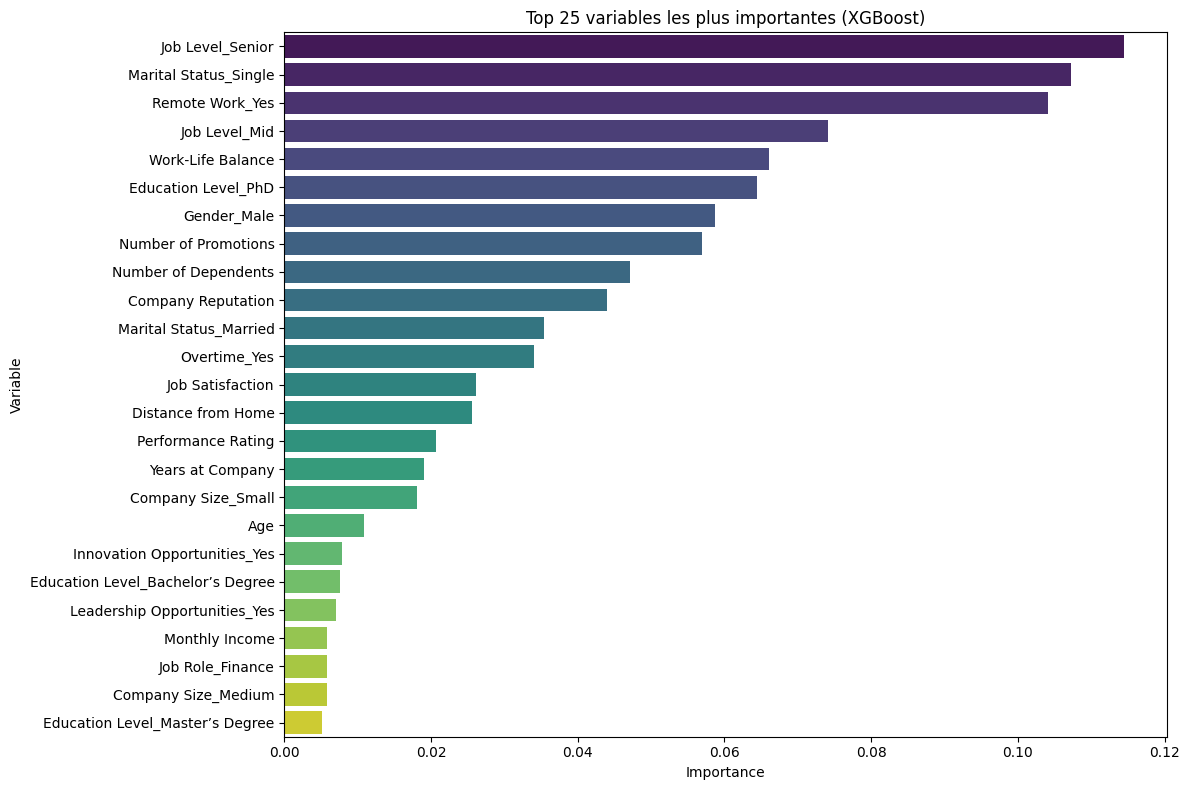

In [ ]:
#  Fonction pour extraire les vrais noms des variables après transformation
def get_feature_names(preprocessor):
    output_features = []
    for name, transformer, cols in preprocessor.transformers_:
        if name in ['num', 'ord']:
            # For fitted transformers, get the actual columns
            if hasattr(transformer, 'get_feature_names_out'):
                 output_features.extend(transformer.get_feature_names_out(cols))
            else:
                 output_features.extend(cols) # Fallback for transformers without get_feature_names_out
        elif name == 'ohe':
            # Check if the transformer is fitted
            if hasattr(transformer, 'categories_'):
                # Use get_feature_names_out for OneHotEncoder
                output_features.extend(transformer.get_feature_names_out(cols))
            else:
                output_features.extend(cols)  # fallback if not fittedb
    return output_features

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Récupération des noms réels après transformation
feature_names = get_feature_names(preprocessor)

xgb_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE()),
    ('clf', models['XGBoost'])
])

xgb_pipe.fit(X_train, y_train)


#  Récupération des importances (XGBoost only)
final_model = xgb_pipe.named_steps['clf']
importances = final_model.feature_importances_

#  Construction du DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

#  Affichage des 25 variables les plus importantes
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(25), x='Importance', y='Feature', palette='viridis')
plt.title("Top 25 variables les plus importantes (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()